# 

```
`# This is formatted as code`
```

**Online Fraud Transaction Prediction with XGBoost**



PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

![](https://miro.medium.com/max/768/1*9LjCJPuRo52sPNxkvTX_WA.jpeg)

1.   List item
2.   List item




This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** -amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
#Library required to Download datasets from shared google drive link
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

In [2]:
pip install google.colab

Note: you may need to restart the kernel to use updated packages.Collecting google.colab
     ---------------------------------------- 0.0/72.9 kB ? eta -:--:--
     ---------------- ----------------------- 30.7/72.9 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 72.9/72.9 kB 994.3 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/11.8 MB 2.2 MB/s eta 0:00:06
     - -------------------------------------- 0.3/11.8 MB 4.1 MB/s eta 0:00:03
     -- ------------------------------------- 0.7/11.8 MB 4.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/11.8 MB 5.8 MB/s eta 0:00:02
     ----- ---------------------------------- 1.6/11.8 MB 7.5 MB/s eta 0:00:02
     -------- ------------------------------- 2.4/11.8 MB 8.9 MB/s eta 0:00:02
     ---------- ---------------

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [848 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\pandas
      copying pandas\conftest.py -> build\lib.win-amd64-cpython-311\pandas
      copying pandas\testing.py -> build\lib.win-amd64-cpython-311\pandas
      copying pandas\_version.py -> build\lib.win-amd64-cpython-311\pandas
      copying pandas\__init__.py -> build\lib.win-amd64-cpython-311\pandas
      creating build\lib.win-amd64-cpython-311\pandas\api
      copying pandas\api\__init__.py -> build\lib.win-amd64-cpython-311\pandas\api
      creating build\lib.win-amd64-cpython-311\pandas\arrays
      copying pandas\arrays\__init__.py -> build\lib.win-amd64-cpython-311\pandas\arrays
      creating build\lib.win-amd64-cpython-311\pandas\compat
      copying 

In [5]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Downloading the Data


In [6]:
#Downloading Dataset FRom Shared Google Drive Link
file_id = '1VNpyNkGxHdskfdTNRSjjyNa5qC9u0JyV'

In [1]:
downloaded = drive.CreateFile({'id':file_id}) 
downloaded.GetContentFile('Fraud.csv')  


NameError: name 'drive' is not defined

In [8]:
df = pd.read_csv('Fraud.csv')

In [9]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##Checking Missing Values

In [10]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
# Counting the occurrences of fraud and no fraud
occ = df['isFraud'].value_counts()
occ

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
# Printing the ratio of fraud cases
fraud_ratio = occ/len(df.index)
fraud_ratio

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

From the above obseravation it seems the ratio of Fraud to Not Fraud is  very low which indicates Unbalanced Data.

In [13]:
# Count the occurrences of isflaggedfraud and no isflaggedfraud
occ_1= df['isFlaggedFraud'].value_counts()
occ_1 

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [14]:
fraud_ratio = occ_1/len(df.index)
fraud_ratio

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

In [15]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


It seems Same for the FlaggedFraud Cases

In [16]:
fraudby_type = df.groupby("type")["isFraud"].count()
fraudby_type


type
CASH_IN     1399284
CASH_OUT    2237500
DEBIT         41432
PAYMENT     2151495
TRANSFER     532909
Name: isFraud, dtype: int64

## Visualizing Datasets

In [17]:
# checking the different types of steps involved in transactions
steps = df['step'].value_counts().nunique()
print("The no. of different steps involved in transactions are :", steps)

The no. of different steps involved in transactions are : 428


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


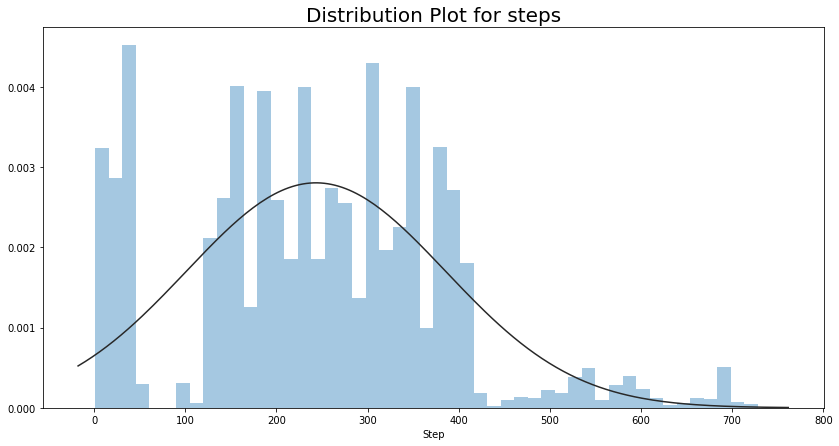

In [18]:
plt.rcParams['figure.figsize'] =(14, 7)
sns.distplot(df.step, fit = norm, kde = False)
plt.title('Distribution Plot for steps', fontsize = 20)
plt.xlabel('Step', fontsize = 10)
plt.show();

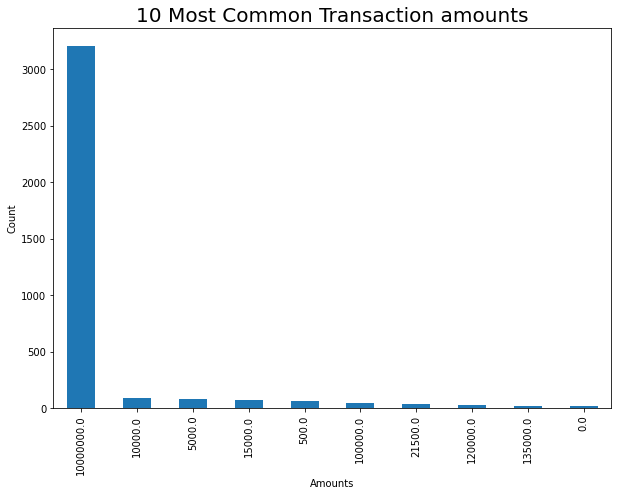

In [19]:
# Checking the different values of amounts transationed
plt.rcParams['figure.figsize'] = (10, 7)
df['amount'].value_counts().head(10).plot.bar()
plt.title('10 Most Common Transaction amounts', fontsize = 20)
plt.xlabel('Amounts')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


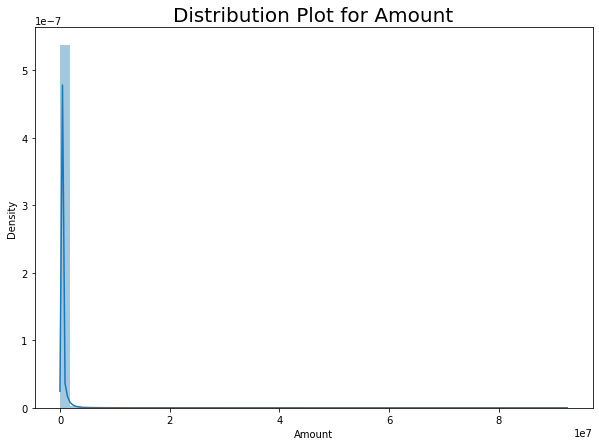

In [20]:
#Distribution Plot for Amount
ax = sns.distplot(df.amount)
ax.set_title(label = 'Distribution Plot for Amount', fontsize = 20)
ax.set_xlabel(xlabel = 'Amount', fontsize = 10)
plt.show()

In [21]:
dfFraudPayment = df.loc[(df.isFraud == 1) & (df.type == 'PAYMENT')]
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
dfFraudCashin = df.loc[(df.isFraud == 1) & (df.type == 'CASH_IN')]
dfFrauddebit = df.loc[(df.isFraud == 1) & (df.type == 'DEBIT')]
print ('The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer)))
print ('The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout)))
print ('The number of fraudulent CASH_Ins = {}'.format(len(dfFraudCashin)))
print ('The number of fraudulent Debits = {}'.format(len(dfFrauddebit)))
print ('The number of fraudulent Payments = {}'.format(len(dfFraudPayment)))

The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116
The number of fraudulent CASH_Ins = 0
The number of fraudulent Debits = 0
The number of fraudulent Payments = 0


From above observations it seem most of Fradulent tranctions was from TRANSFERS and CASH_OUT

In [22]:
# Finding out the minimum and maximum transaction from Transfer and cash out transaction mode when it is set to be Fraud

print("Transfer Transaction")
print("Minimum Transaction :", df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')].amount.min())
print("Maximum Transaction :", df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')].amount.max())

print("\nCASH_OUT Transaction")
print("Minimum Transaction :", df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')].amount.min())
print("Maximum Transaction :", df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')].amount.max())

Transfer Transaction
Minimum Transaction : 63.8
Maximum Transaction : 10000000.0

CASH_OUT Transaction
Minimum Transaction : 0.0
Maximum Transaction : 10000000.0


In [23]:
# Figuringing out the no. of flagged fraudulent transactions
FlaggedFraud = df.loc[(df.isFlaggedFraud == 1) & (df.type == 'TRANSFER')]
print("The no. of Flagged Fraudulent Transactions :", len(FlaggedFraud))

# Printing the minimum and maximum transactions done when FlaggedFraud is set
# The Transaction mode being Transfer
print("Minimum Transaction :", df.loc[df.isFlaggedFraud == 1].amount.min())
print("Maximum Transaction :", df.loc[df.isFlaggedFraud == 1].amount.max())

The no. of Flagged Fraudulent Transactions : 16
Minimum Transaction : 353874.22
Maximum Transaction : 10000000.0


#  Dataset where only Transfer Transactions are mentioned

In [24]:
# Defining a dataset containing only transfer type of transactions
dataTransfer = df.loc[df['type'] == 'TRANSFER']
dataTransfer = pd.DataFrame(dataTransfer)
dataTransfer.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0
79,1,TRANSFER,77957.68,C207471778,0.00,0.0,C1761291320,94900.00,22233.65,0,0
80,1,TRANSFER,17231.46,C1243171897,0.00,0.0,C783286238,24672.00,0.00,0,0
81,1,TRANSFER,78766.03,C1376151044,0.00,0.0,C1749186397,103772.00,277515.05,0,0
82,1,TRANSFER,224606.64,C873175411,0.00,0.0,C766572210,354678.92,0.00,0,0
83,1,TRANSFER,125872.53,C1443967876,0.00,0.0,C392292416,348512.00,3420103.09,0,0


In [25]:
# Frauds having same old and new balance
# Sorted by old orignal balance to check original old balance for flagged frauds
dataTransfer.loc[(dataTransfer.isFlaggedFraud == 1) & (dataTransfer.oldbalanceOrg == dataTransfer.newbalanceOrig)].sort_values(by = 'oldbalanceOrg').head(10)
# This table shows flagged frauds with minimum original old balance

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6351225,702,TRANSFER,3171085.59,C1892216157,3171085.59,3171085.59,C1308068787,0.0,0.0,1,1
6296014,671,TRANSFER,3441041.46,C917414431,3441041.46,3441041.46,C1082139865,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
6362584,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.0,0.0,1,1


In [26]:
# Frauds having same old and new balance
# Sorted by old orignal balance to check original old balance for flagged frauds
dataTransfer.loc[(dataTransfer.isFlaggedFraud == 1) & (dataTransfer.oldbalanceOrg == dataTransfer.newbalanceOrig)].sort_values(by = 'oldbalanceOrg').tail(10)
# This table shows flagged frauds with minimum original old balance

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
6362584,741,TRANSFER,5674547.89,C992223106,5674547.89,5674547.89,C1366804249,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1
6281484,646,TRANSFER,399045.08,C724693370,10399045.08,10399045.08,C1909486199,0.0,0.0,1,1
6362460,730,TRANSFER,10000000.00,C2140038573,17316255.05,17316255.05,C1395467927,0.0,0.0,1,1
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1


In [27]:
# Finding out the minimum and maximum amount for oldbalance original where oldbalance and newbalance for dest is same.

dataFlagged = df.loc[df.isFlaggedFraud == 1]

print('Minimum Balance of oldBalanceOrig for FlaggedFraud and Transfer mode :', dataFlagged.oldbalanceOrg.min())
print('Maximum Balance of oldbalanceOrig for FlaggedFraud and Transfer mode :', dataFlagged.oldbalanceOrg.max())

Minimum Balance of oldBalanceOrig for FlaggedFraud and Transfer mode : 353874.22
Maximum Balance of oldbalanceOrig for FlaggedFraud and Transfer mode : 19585040.37


In [28]:
#Since frad has occured for type TRANSFER AND CASHOUT
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]
X.shape

(2770409, 11)

In [29]:
X.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [30]:
# Removing Unwanted columns

X = X.drop(['nameDest','nameOrig'], axis = 1)
X.shape

(2770409, 9)

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [31]:
#Adding New Features to Dataset
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest
X.shape

(2770409, 11)

In [32]:
#One Hot Encoding For Categorical Variable Type
X['type'].replace('TRANSFER', 0, inplace = True)
X['type'].replace('CASH_OUT', 1, inplace = True)

In [33]:
X.head(10)


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.00,0.0,0.0,0.00,1,0,0.00,181.00
3,1,1,181.00,181.00,0.0,21182.0,0.00,1,0,0.00,21363.00
15,1,1,229133.94,15325.00,0.0,5083.0,51513.44,0,0,213808.94,182703.50
19,1,0,215310.30,705.00,0.0,22425.0,0.00,0,0,214605.30,237735.30
24,1,0,311685.89,10835.00,0.0,6267.0,2719172.89,0,0,300850.89,-2401220.00
42,1,1,110414.71,26845.41,0.0,288800.0,2415.16,0,0,83569.30,396799.55
47,1,1,56953.90,1942.02,0.0,70253.0,64106.18,0,0,55011.88,63100.72
48,1,1,5346.89,0.00,0.0,652637.0,6453430.91,0,0,5346.89,-5795447.02
51,1,1,23261.30,20411.53,0.0,25742.0,0.00,0,0,2849.77,49003.30
58,1,0,62610.80,79114.00,16503.2,517.0,8383.29,0,0,0.00,54744.51


In [34]:
#Checiking the No of Fraus cases in New Datasets
X['isFraud'].value_counts()


0    2762196
1       8213
Name: isFraud, dtype: int64

In [35]:
# Prearing Datasets
Y = X['isFraud'] # Target Variable

X = X.drop(['isFraud'], axis = 1) # REmoving target variable
print("Shape of x: ", X.shape)
print("Shape of y: ", Y.shape)

Shape of x:  (2770409, 10)
Shape of y:  (2770409,)


In [36]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0


In [37]:
Y.head()


2     1
3     1
15    0
19    0
24    0
Name: isFraud, dtype: int64

#Appling Oversampling technique SMOTE for Balanced Datasets


In [38]:
from imblearn.over_sampling import SMOTE
method = SMOTE()
X_resampled, y_resampled = method.fit_sample(X, Y)

print("Shape of X: ", X_resampled.shape)
print("Shape of Y:", y_resampled.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of X:  (5524392, 10)
Shape of Y: (5524392,)


# Splitting the dataset into train and tests


In [39]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)


In [40]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)

print("Shape of x_test: ", x_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of x_train:  (4419513, 10)
Shape of y_train:  (4419513,)
Shape of x_test:  (1104879, 10)
Shape of y_test:  (1104879,)


In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#Building XGBoost Model For Prediction

In [42]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=2)


In [43]:
%%time
model.fit(x_train, y_train)

[06:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:38] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 3min 38s, sys: 685 ms, total: 3min 39s
Wall time: 1min 53s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [44]:
x_preds = model.predict(x_train)


In [45]:
from sklearn.metrics import average_precision_score
auprc = average_precision_score(y_train, x_preds)
print("The Area under Precision Recall Curve Score For x_train is", auprc)

The Area under Precision Recall Curve Score For x_train is 0.9979298671613831


In [46]:
y_preds = model.predict(x_test)
auprc = average_precision_score(y_test, y_preds)
print("The Area under Precision Recall Curve Score For y_train is", auprc)

The Area under Precision Recall Curve Score For y_train is 0.9979298805438651


In [47]:
X.columns

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
       'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')

#Visualising Tree


In [48]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 30,30

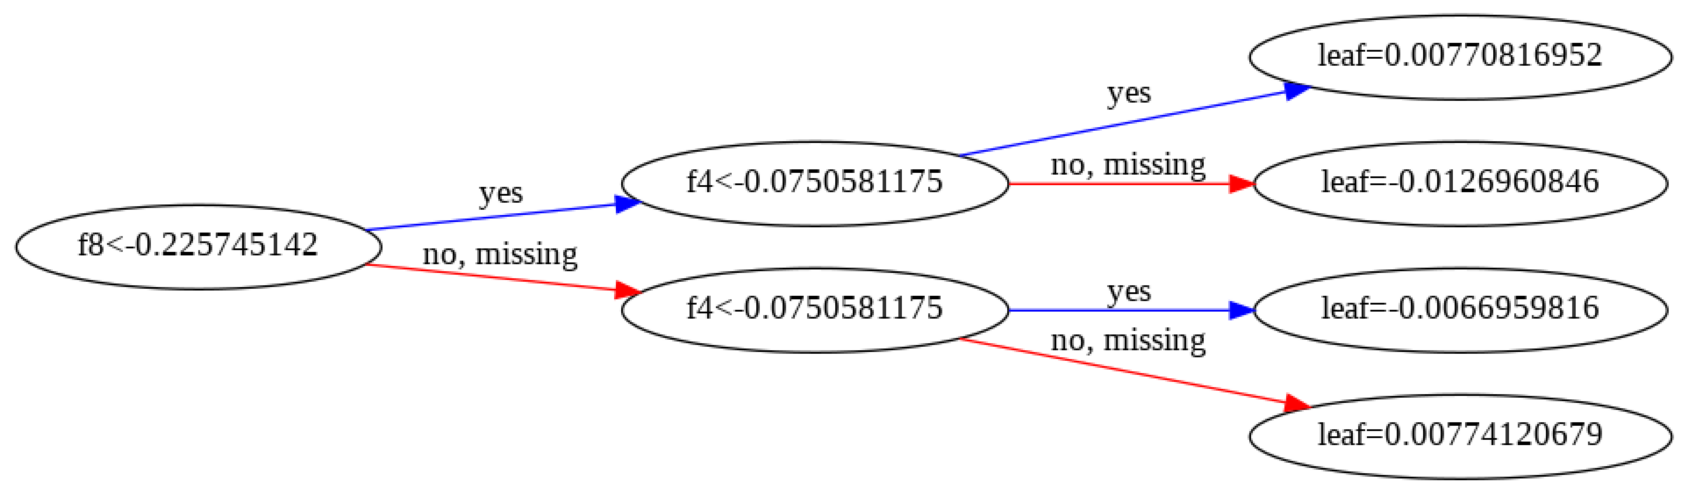

In [49]:
plot_tree(model, rankdir='LR', num_trees=19);


##Feature importance


In [50]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [51]:
importance_df.head(10)


,feature,importance
8,errorBalanceOrig,0.838497
4,newbalanceOrig,0.112740
9,errorBalanceDest,0.046456
7,isFlaggedFraud,0.001295
3,oldbalanceOrg,0.001012
0,step,0.000000
1,type,0.000000
2,amount,0.000000
5,oldbalanceDest,0.000000
6,newbalanceDest,0.000000


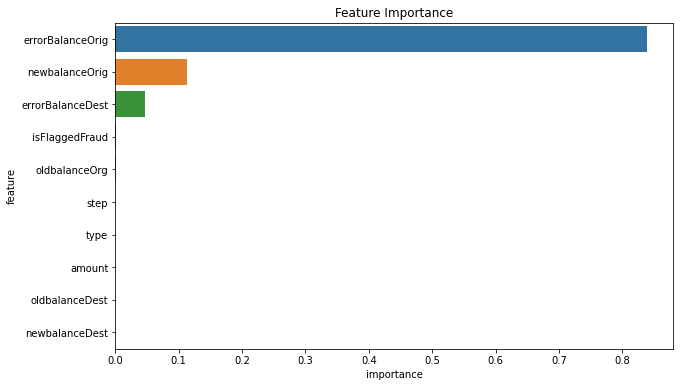

In [52]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

##From Observing 19th Tree and Feature importance Table, we can conclude the most imortant features is Error Balance origin.

In [53]:
#Comparing actual outcomes v/s predicted outcomes
from sklearn.metrics import accuracy_score
y_pred = (y_preds > 0.5)

myaccuracy=accuracy_score(y_test,y_pred)
print( myaccuracy)

0.9890521948557263


## Let's also implement a Logistic Regression model and Decide, what is best ?

In [55]:
# Fit a logistic regression model to our data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
# Obtain model predictions
predicted = model.predict(x_test)

In [58]:
# Print the classifcation report and confusion matrix
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95    551906
           1       0.95      0.96      0.95    552973

    accuracy                           0.95   1104879
   macro avg       0.95      0.95      0.95   1104879
weighted avg       0.95      0.95      0.95   1104879

Confusion matrix:
 [[521541  30365]
 [ 24311 528662]]


In [60]:
accuracy1=accuracy_score(y_test,predicted)
print(accuracy1)

0.9505140381887971


## Comparing the Accuracy Score Ofabove two Models, We can conclude Accuray of XGBoost Model is Highest

In [61]:
jovian.commit
jovian.submit(assignment="zerotogbms-project")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/lavkushgupt/online-fraud-prediction-using-xgboost
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/machine-learning-with-python-zero-to-gbms/assignment/course-project-real-world-machine-learning-model
